In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## 載入必要的套件

In [1]:
import numpy as np
import torch
#建立神經網路用
import torch.nn as nn
import torch.nn.functional as F
#載入優化器
from torch import optim
#預處理資料用
from torch.utils.data import Dataset,DataLoader
import matplotlib.pyplot as plt
import matplotlib.font_manager as plt_font
folder="/content/drive/MyDrive/解密AI黑盒子分享/"
twfont1 = plt_font.FontProperties(fname=folder+"字型/kaiu.ttf")
from IPython import display
import time
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

## 建立DataSet類別

In [2]:
class MyDataset(Dataset):		#需要繼承Dataset 
    def __init__(self,TrainorTest): 
        if TrainorTest==1:
            data=np.loadtxt(folder+"資料集/fashion-MNIST/fashion-mnist_train.csv",delimiter=",")
        else:
            data=np.loadtxt(folder+"資料集/fashion-MNIST/fashion-mnist_test.csv",delimiter=",")
        data_x=data[:,1:]
        data_y=data[:,0]
        self.data=torch.tensor(data_x)
        self.label=torch.tensor(data_y)
    def __getitem__(self,index): 
        # 處理資料(縮放、變形、、、)
        return self.data[index].reshape(1,28,28)/255, self.label[index]
    def __len__(self): 
        #資料集的總筆數
        return len(self.data)
TrainDS=MyDataset(1)
TrainDL=DataLoader(dataset=TrainDS,batch_size=1000,shuffle=True)
TestDS=MyDataset(0)
TestDL=DataLoader(dataset=TestDS,batch_size=len(TestDS),shuffle=False)

## 建立神經網路

In [3]:
class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(1,64,5)  #卷積層：輸入頻道數=1,卷積核數量=64,卷積核尺寸=5*5
        self.pool = nn.MaxPool2d(2,2)      #池化層：池化區尺寸=2*2
        self.conv2 = nn.Conv2d(64,32,5)   #卷積層：輸入頻道數=64,卷積核數量=32,卷積核尺寸=5*5
        #全連接層
        self.fc1 = nn.Linear(32*4*4,128) # 32 channel, 4 * 4 size(經過Convolution部分後剩4*4大小)
        self.fc2 = nn.Linear(128,64)
        self.fc3 = nn.Linear(64,64)
        self.fc4 = nn.Linear(64,10)
    def forward(self, x):
        x = self.conv1(x)   #卷積後的尺寸24x24
        x = F.relu(x)
        x = self.pool(x)    #池化後的尺吋12x12
        x = self.conv2(x)   #卷積後的尺寸8x8
        x = F.relu(x)
        x = self.pool(x)    #池化後的尺寸4x4
        x = x.reshape(-1, 32 * 4 * 4)#進入全連接層前先拉平
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        x = self.fc4(x)
        return x
net = Net().to(device) # inital network 
optimizer = optim.Adam(net.parameters(), lr=0.0020)  # create a Adam optimizer
LossFun=nn.CrossEntropyLoss()

## 開始訓練神經網路

In [4]:
net.train()
epochs = 100
step_loss=[]
starttime=time.time()
for i in range(epochs):
    for data,label in TrainDL:
        optimizer.zero_grad()
        predicted = net(data.float().to(device))
        loss = LossFun(predicted,label.long().to(device))
        loss.backward()
        optimizer.step()
        step_loss.append(float(loss))
    print("訓練回合：",i+1,"損失值：",loss)
    display.clear_output(wait=True)
print("總共訓練時間：",time.time()-starttime)

總共訓練時間： 174.74489998817444


## 訓練時LOSS變化

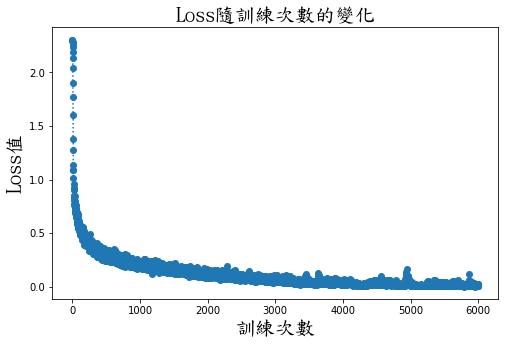

In [5]:
plt.figure(figsize=(8,5))
plt.title("Loss隨訓練次數的變化",fontproperties=twfont1,fontsize=20) 
plt.xlabel("訓練次數",fontproperties=twfont1,fontsize=20) 
plt.ylabel("Loss值",fontproperties=twfont1,fontsize=20)
plt.plot(step_loss,":o")
plt.show()

In [6]:
net.eval()
correct = 0
with torch.no_grad():
    for data,label in TestDL:
        output = net(data.float().to(device))
        correct += (torch.argmax(output, dim=1) == label.to(device)).sum().item()
print("驗證資料準確度：",round(correct/len(TestDS),3))

驗證資料準確度： 0.91
